In [53]:
import pandas as pd
from  datetime import datetime
import numpy as np
import AppVectorizerModule as ATV

from nltk.corpus import stopwords
from sklearn.decomposition import PCA

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline  

In [39]:
# Reading data
path='../data/smalldata.csv'
data= pd.read_csv(path,sep=',',header=0)
print data.columns
df = data[['userid','artist_name','artistid','plays','gender','age','country','dos']]

Index([u'userid', u'artistid', u'artist_name', u'plays', u'gender', u'age',
       u'country', u'dos'],
      dtype='object')


In [40]:
def mapGender(x):
    if x=='m':
        return -1
    else:
        return 1

# Extracts how the number of months from that date to current system date.
def mapDates(d):
    d1= datetime.now()
    d2=datetime.strptime(d, "%b %d, %Y")
    return (d1.year - d2.year)*12 + d1.month - d2.month

def mapAges(x):
    if x>0 and x<=10: #children
        return 0
    elif x>10 and x<=20: #teenagers
        return 2 
    elif x>20 and x<=40: #adults
        return 3
    elif x>40: #old
        return 4

In [41]:
df.gender= map(mapGender,df.gender)
df.dos= map(mapDates,df.dos)
df.age= map(mapAges,df.age)

In [42]:
print len(df.age)
print np.unique(df.age)
df=df.dropna(subset=['age'],how='all')
print len(df.age)
print np.unique(df.age)

10000
[  2.   3.   4. ...,  nan  nan  nan]
8119
[ 2.  3.  4.]


In [8]:
len(df)

8119

In [9]:
len(np.unique(df.artistid))

4462

In [43]:
listArtist=pd.DataFrame(df.groupby('userid')['artist_name'].apply(lambda x: "%s" % ' '.join(x))).sort()
sumPlays=pd.DataFrame(df.groupby('userid')['plays'].sum()).sort()
sumPlays=sumPlays.reset_index()

otherFeatures=df[['userid','gender','age','country','dos']]
otherFeatures=otherFeatures.drop_duplicates()
otherFeatures=otherFeatures.sort('userid')
otherFeatures=otherFeatures.reset_index()

In [11]:
# Vectorising the features and merging them to selected numerical features     
min_df=1
max_df=0.9
lowercase=True
stem_vectorizer = ATV.StemmedCountVectorizer(encoding='utf-8',
                                         min_df =min_df,
                                         max_df =max_df,
                                         stop_words='english',
                                         analyzer='word',
                                         lowercase = lowercase)
                
##set filterparameter to your vectorizer
filter_by=["OnlyEng", "AllLang"] #two options are available
count_dialect = True 
stem_vectorizer.setfilter_option(filter_by[1],count_dialect)    

# Vectorizing the Category Column
nArtistName, fmatrix, column_vectorizer = ATV.vectorize_columnTfIdf(listArtist, 'artist_name',stem_vectorizer,listArtist.shape[0],True)
nCountry, fmatrix_2, column_vectorizer_2 = ATV.vectorize_columnTfIdf(otherFeatures,'country',stem_vectorizer,otherFeatures.shape[0],True)

formed dataframe of size:( 166 , 5550 )
formed dataframe of size:( 166 , 47 )


In [30]:
final_X=pd.concat([nArtistName,nCountry,sumPlays['plays'],otherFeatures[['dos','gender']]],axis=1)

In [31]:
final_y=otherFeatures[['age']]

In [48]:
resultpath='../results/'
resultFile=open(resultpath+'Results_Classifier'+'.csv', 'w+')
resultFile.write('Components,Classifier,Accuracy,Precision,Recall')

In [49]:
def getClassifierName(clf):
    if type(clf).__name__ != 'OneVsRestClassifier':
        #print type(clf).__name__
        return type(clf).__name__
    else:
        #print type(clf.estimator).__name__
        return type(clf.estimator).__name__

In [51]:
#resultpath='../clf_results/'
#n_components=[finaldf.shape[1]/int(4),finaldf.shape[1]/int(3),finaldf.shape[1]/int(2),finaldf.shape[1]]
#n_components=[2,6,8]
#n_components=[20,30,40]
n_components=[100,200,500,1000,final_X.shape[1]]
n_kfolds=10

classifiers = [GaussianNB(),BernoulliNB(),RandomForestClassifier(),LogisticRegression(),SGDClassifier(),RidgeClassifier()              ,DecisionTreeClassifier(),KNeighborsClassifier(),LinearSVC()]
classifierName=['GaussianNB','Bernauli','RandomForest','LogisticRegression','SDGC','RidgeClassifier','DecsionTree','KNeighbour','LinearSVC']
#classifiers=[RandomForestClassifier()]
#classifierName=['RandomForest']
n_component_accuracies = []

for n in n_components:
    xx=final_X.copy()
    pca = PCA(n_components=n)
    xx= pca.fit_transform(xx)
    yy=final_y.values
    accuracies=[]
    for clf in classifiers:
            clfname=getClassifierName(clf)
            #print len(xx),clfname
            print 'Start'+clfname
            kf = KFold(len(xx),n_kfolds)
            accuracy=0
            precision=0
            recall=0
            for train_index,test_index in kf:
                X_train, X_test, y_train, y_test = xx[train_index],xx[test_index],yy[train_index],yy[test_index]
                clf.fit(X_train,y_train)                
                y_pred=clf.predict(X_test)
                accScore=accuracy_score(y_test,y_pred)
                precisionScore=precision_score(y_test,y_pred,pos_label=None)
                recallScore=recall_score(y_test,y_pred,pos_label=None)
                #print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0],(y_test != y_pred).sum()))
                accuracy += accScore
                precision += precisionScore
                recall += recallScore
            print("Components:%f Classifier:%s Accuracy Score:%f"%(n,clf,accuracy/n_kfolds)) 
            resultFile.write("\n%f,%s,%0.3f,%0.3f,%0.3f"%(n,clfname,accuracy/n_kfolds,precision/n_kfolds,recall/n_kfolds))
            accuracies.append(accuracy/n_kfolds)
            print 'End'+clfname
    n_component_accuracies.append(accuracies)
resultFile.close()

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted

StartGaussianNB
Components:100.000000 Classifier:GaussianNB() Accuracy Score:0.620588
EndGaussianNB
StartBernoulliNB
Components:100.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.602941

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndBernoulliNB
StartRandomForestClassifier
Components:100.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.566544

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.1


EndRandomForestClassifier
StartLogisticRegression
Components:100.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.705147

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndLogisticRegression
StartSGDClassifier
Components:100.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.322794
EndSGDClassifier
StartRidgeClassifier
Components:100.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.662132

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weight


EndRidgeClassifier
StartDecisionTreeClassifier
Components:100.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.561397

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for in


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:100.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.573162
EndKNeighborsClassifier
StartLinearSVC
Components:100.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.493750
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


Components:200.000000 Classifier:GaussianNB() Accuracy Score:0.595588
EndGaussianNB
StartBernoulliNB
Components:200.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.567647

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndBernoulliNB
StartRandomForestClassifier
Components:200.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.573162

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.1


EndRandomForestClassifier
StartLogisticRegression
Components:200.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.711029

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndLogisticRegression
StartSGDClassifier
Components:200.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.200000
EndSGDClassifier
StartRidgeClassifier
Components:200.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.704779

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weight


EndRidgeClassifier
StartDecisionTreeClassifier
Components:200.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.513235

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for in


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:200.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.573162
EndKNeighborsClassifier
StartLinearSVC
Components:200.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.379044
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


Components:500.000000 Classifier:GaussianNB() Accuracy Score:0.595588
EndGaussianNB
StartBernoulliNB
Components:500.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.567647

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted


EndBernoulliNB
StartRandomForestClassifier
Components:500.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.560662

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.1


EndRandomForestClassifier
StartLogisticRegression
Components:500.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.711029

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndLogisticRegression
StartSGDClassifier
Components:500.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.354044
EndSGDClassifier
StartRidgeClassifier
Components:500.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.704779

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weight


EndRidgeClassifier
StartDecisionTreeClassifier
Components:500.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.489706

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for in


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:500.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.573162
EndKNeighborsClassifier
StartLinearSVC
Components:500.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.417647
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


Components:1000.000000 Classifier:GaussianNB() Accuracy Score:0.595588
EndGaussianNB
StartBernoulliNB
Components:1000.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.567647

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndBernoulliNB
StartRandomForestClassifier
Components:1000.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.638235

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted


EndRandomForestClassifier
StartLogisticRegression
Components:1000.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.711029

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndLogisticRegression
StartSGDClassifier
Components:1000.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.378309
EndSGDClassifier
StartRidgeClassifier
Components:1000.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.704779

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for in


EndRidgeClassifier
StartDecisionTreeClassifier
Components:1000.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.506985

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:1000.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.573162
EndKNeighborsClassifier
StartLinearSVC
Components:1000.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.518015
EndLinearSVC
StartGaussianNB

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


Components:5600.000000 Classifier:GaussianNB() Accuracy Score:0.595588
EndGaussianNB
StartBernoulliNB
Components:5600.000000 Classifier:BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) Accuracy Score:0.567647

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted


EndBernoulliNB
StartRandomForestClassifier
Components:5600.000000 Classifier:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Accuracy Score:0.578676

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/lib/python2.7/site-packages/ipykernel/__main__.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.1


EndRandomForestClassifier
StartLogisticRegression
Components:5600.000000 Classifier:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0) Accuracy Score:0.711029

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted


EndLogisticRegression
StartSGDClassifier
Components:5600.000000 Classifier:SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False) Accuracy Score:0.254044
EndSGDClassifier
StartRidgeClassifier
Components:5600.000000 Classifier:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='auto', tol=0.001) Accuracy Score:0.704779

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weight


EndRidgeClassifier
StartDecisionTreeClassifier
Components:5600.000000 Classifier:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best') Accuracy Score:0.524632

/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for in


EndDecisionTreeClassifier
StartKNeighborsClassifier
Components:5600.000000 Classifier:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform') Accuracy Score:0.573162
EndKNeighborsClassifier
StartLinearSVC
Components:5600.000000 Classifier:LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) Accuracy Score:0.337132
EndLinearSVC


/home/ayush/Documents/big-data/bigdata-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


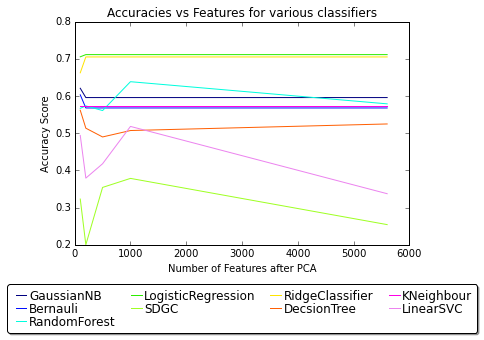

In [55]:
# Plotting the graph
plotarrays=np.array(n_component_accuracies)
data = []
for i in range(0,len(classifiers)):
    a=plotarrays[:,i]
    trace = go.Scatter(
        x = n_components,
        y = a,
        name=classifierName[i]
    )
    data.append(trace)
if(True):
    # Plot using matplotlib
    num_plots = len(classifiers)
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])
    # Plot several different functions...
    labels = []
    for i in range(0, num_plots):
        a=plotarrays[:,i]
        #print n_components ,a
        plt.plot(n_components,a)
        labels.append(classifierName[i])

    plt.legend(labels, ncol=4, loc='upper center', 
               bbox_to_anchor=[0.5, -0.15], 
               columnspacing=1.0, labelspacing=0.0,
               handletextpad=0.0, handlelength=1.5,
               fancybox=True, shadow=True)
    
    plt.xlabel('Number of Features after PCA')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracies vs Features for various classifiers')

    #plt.show()
    plt.savefig(resultpath+'Result_classifier')